# Анализ результатов A/B теста 

### Описание проекта

Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
pd.set_option('display.max_colwidth', 255)
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Датафрейм hypothesis содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. 

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Для удобства приведем названия столбцов к единому регистру:

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

Результаты AB теста содержатся в датафреймах orders и visitors:

In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В orders содержатся данные о сделанных заказах:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [6]:
orders.columns = orders.columns.str.lower()

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.groupby('group').agg({'visitorid' : 'nunique', 'revenue': 'sum'})

,visitorid,revenue
group,,
A,503,4084803
B,586,5907760


В группе В больше пользователей и больше сумма выручки. На конверсию и средний чек это не влияет, все нормально. 

In [9]:
orders.groupby('visitorid').agg({'group' : 'nunique'}).query('group == 2').count()

group    58
dtype: int64

58 человек попали в обе группы. Посмотрим, что в других таблицах, а потом примем решение, что можно с этим сделать.

Для удобства приведем поле date к нужному формату: 

In [10]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


В visitors содержится информация о посетителях:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [13]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [14]:
visitors.groupby('group').agg({'visitors' : 'sum'})

,visitors
group,
A,18736
B,18916


В группе В также больше количество посетителей.

Т.к. данные в visits агрегированные, то пользователей, попавших в обе группы мы исключить не можем.

#### Вывод

Посмотрели данные, изменили формат данных (поле date), обнаружили, что 58 пользователей попало в обе группы. Но т.к. данные в таблице visits агрегированные, исключить этих пользователей мы не можем. 

### Приоритизация гипотез.

#### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [15]:
hypothesis['ICE'] = round(( hypothesis['impact'] * hypothesis['confidence'] ) / hypothesis['efforts'], 2)

In [16]:
hypothesis.sort_values(by = 'ICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


На первом месте по приоритету - "**Запустить акцию, дающую скидку на товар в день рождения**" <br>
На последнем -"**Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей**"

####  Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [17]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] ) /hypothesis['efforts'], 2)

In [18]:
hypothesis.sort_values(by = 'RICE', ascending = False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


При применении RICE приоритеты сместились: на первом месте теперь "**Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**". <br>
На последнем все так же "**Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей**"


Метод RICE, в отличие от метода ICE, включает в себя параметр Reach - скольких пользователей затронет изменение. С этим связано изменение приоритизации гипотез:<br>
Запуск акции, дающую скидку на товар в день рождения (на первом месте по приоритизации методом ICE) затронет куда меньшее количество пользователей - 1 по шкале от 1 до 10, в то время как добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - затронет практически всех пользователей: параметр Reach данной гипотезы равен 10. 

#### Вывод

Методами ICE и RICE провели приоритизацию гипотез: <br>
- Метод  ICE: <br>
На первом месте гипотеза о запуске акции, дающей скидку в день рождения, на последнем -изменение цвета фона главной страницы
- Метод RICE: <br>
На первом месте гипотеза о добавлении формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, на последнем всё так же изменение цвета фона главной страницы
       
Разница в приоритизации этих двух методов заключается в том, что метод RICE, в отличие от метода ICE, учитывает количество пользователей, которых затронет это изменение. 
    

### Анализ A/B-теста

#### Постройте график кумулятивной выручки по группам.

Создадим массив уникальных пар значений дат и групп теста:

In [19]:
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


Соберём агрегированные кумулятивные по дням данные о заказах:

In [20]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(
           orders['date'] <= x['date'], orders['group'] == x['group']
    )].agg(
        {'date' : 'max' 
         , 'group' : 'max'
         , 'transactionid' : pd.Series.nunique
         , 'visitorid' : pd.Series.nunique
             , 'revenue' : 'sum'}), axis = 1
).sort_values(by = ['date', 'group'])


In [21]:
ordersAggregated

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


Данные по визитам:

In [22]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(
        visitors['date'] <= x['date'], visitors['group'] == x['group']
                                     )].agg({'date' : 'max'
                                             , 'group' : 'max'
                                             , 'visitors' : 'sum'}
                                           ), axis=1
).sort_values(by=['date','group'])


Данные по дням для разных групп теста:

In [23]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date'
                                    , 'transactionid'
                                    , 'visitorid'
                                    , 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date'
                                    , 'transactionid'
                                    , 'visitorid'
                                    , 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']


visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

Объединяем агрегированные данные по заказам и визитам:

In [25]:
cumulativeData = ordersAggregated.merge(visitorsAggregated
                                        , left_on = ['date', 'group']
                                        , right_on = ['date', 'group'])

Для удобства переименуем колонки:

In [26]:
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [27]:
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Данные по выручке для разных групп теста:

In [28]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


Построим график кумулятивной выручки по группам:

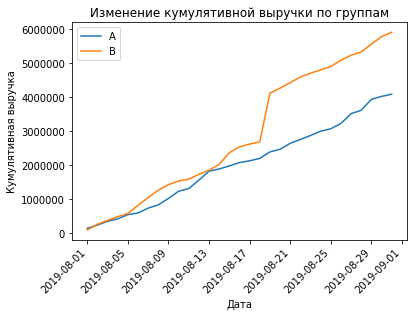

In [29]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title('Изменение кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.xticks(rotation=45, ha='right');


Как видно по графику, выручка в группе В резко начала увеличиваться по сравнению с выручкой группы А: рост выручки в этой группе был практически равномерным. 

#### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения

Построим график кумулятивного среднего чека по группам, для этого разделим выручку на количество заказов:

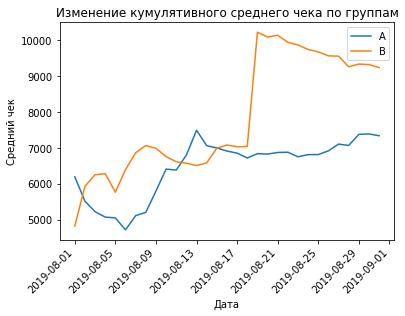

In [30]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Изменение кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=45, ha='right');

Средний чек в группе А в начале показывал рост, но к середине теста начал постепенно незначительно снижаться - но в целом сильных изменений не претерпевал. <br>
А вот в группе В этот показатель во второй половине экспримента показал резкий рост с постепенным снижением, но всё же показатели остались выше, чем в группе А.

#### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

Объединим данные по кумулятивной выручке для разных групп:

In [31]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB
                                                   , left_on='date'
                                                   , right_on='date'
                                                   , how='left'
                                                   , suffixes=['A', 'B']) 


Построим график относительного изменения кумулятивного среднего чека группы B к группе A:

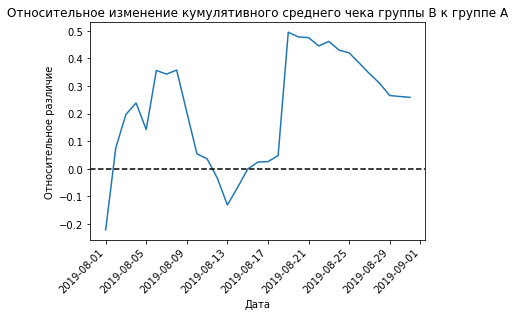

In [32]:

plt.plot(mergedCumulativeRevenue['date']
         , (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) /
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)


plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right');

Группа B лишь в начале и середине эксперимента была хуже группы A по среднему чеку, но в целом средний чек в группе В выше.

#### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

Посчитаем конверсию для двух групп: 

In [33]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


Построим график кумулятивной конверсии по группам:

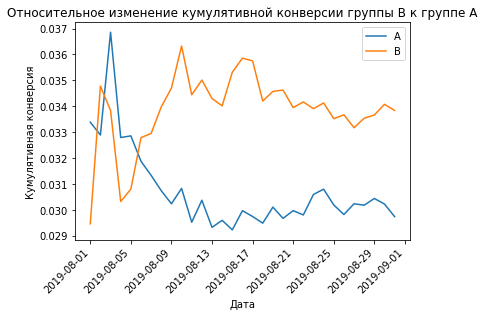

In [34]:
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')

plt.axis()
plt.xticks(rotation=45, ha='right');

В начале теста были колебания конверсии в обеих группах. Конверсия в группе А была лучше только в самом начале эксперимента. Далее конверсия в группе А начала снижаться, а в группе В, наоборот, расти. 

#### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

Объединим данные по двум группам и построим график:

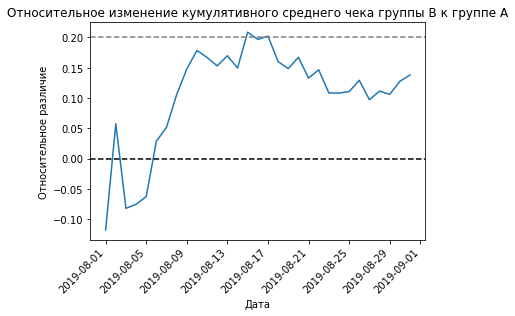

In [35]:
mergedCumulativeConversions = cumulativeDataA[['date'
                                               , 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']]
    , left_on = 'date'
    , right_on = 'date'
    , how='left'
    , suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.xticks(rotation=45, ha='right');


Этот график подтверждает предыдущий вывод. Конверсия в группе А была выше только в начале эксперимента, далее показатели группы В были стабильно выше. 

#### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Посчитаем колиество заказов по пользователям и отсортируем их:

In [36]:
ordersByUsers = (
    orders
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorid', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head()

,visitorid,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Построим точечный график:

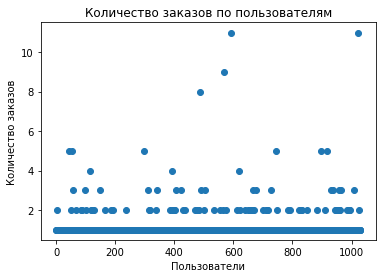

In [37]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов');

Большинство покупателей заказывали только один раз. Но много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [38]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 2. 4.]


Большинство покупателей заказывали только один раз. Не более 5% заказывают больше двух раз  и не более 1% заказывают чаще четырёх раз.
Разумно выбрать 4 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

#### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

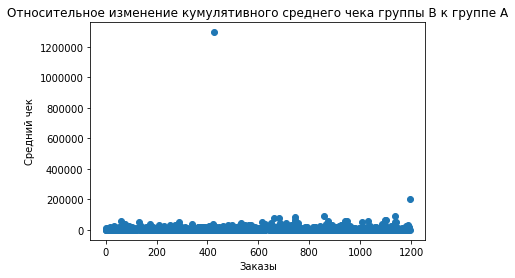

In [39]:
x_values = pd.Series(range(0, len(orders['revenue'])))


plt.scatter(x_values, orders['revenue']) 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Заказы')
plt.ylabel('Средний чек');

Заказов стоимостью 200 000 немного - в основном все заказы ниже этой сумме. Есть несколько выбросов выше. <br>
Изменим диапазон значений по оси ОУ: 

(0, 150000)

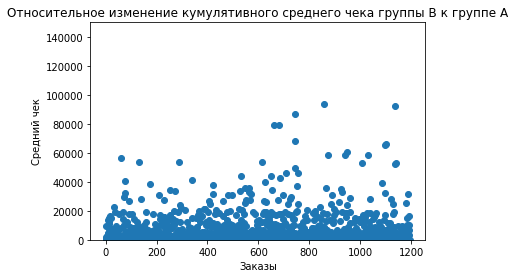

In [40]:
plt.scatter(x_values, orders['revenue']) 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Заказы')
plt.ylabel('Средний чек')
plt.ylim(0, 150000)

Теперь видно: стоимость большинства заказов не превышает 60 000. Для определения аномальных заказов посчитаем 95 и 99 перцентили. 

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [41]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58233.2 рублей. <br>
Примем за аномальных пользователей тех, кто совершил заказ дороже 35 000 рублей. Так мы уберём  от 1% до 5% пользователей с дорогими заказами. 

#### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

Посчитаем количество заказов по пользователям:

In [42]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули: 

In [43]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Конверсия групп А и В не различаются
- Альтернативная гипотеза H₁: Конверсия групп А и В различается


Посчитаем статистическую значимость различий в конверсии между группами:

In [44]:
alpha = 0.05
p_value = stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]


if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print(round(p_value , 3))
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

Отвергаем нулевую гипотезу
0.017
0.138


P-value меньше 0.05, что свидетельствует о статистически значимой разнице в конверсии между группами: нулевую гипотезу отвергаем. <br>
Разница составляет 13,8%. 

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Средний чек групп А и В не различается <br>
- Альтернативная гипотеза H₁: Средний чек групп А и В различается

In [45]:
alpha = 0.05
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue']
                             , orders[orders['group']=='B']['revenue']
                             , alternative = 'two-sided')[1]


if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print(round(p_value , 3))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Не получилось отвергнуть нулевую гипотезу
0.729
0.259


P-value значительно больше 0.05. Отвергнуть нулевую гипотезу о том, что средний чек групп не различается, не удалось.  <br>
При этом средний чек группы А значительно ниже среднего чека группы B. Разница составляет 25,9%.


#### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

Найденные ранее 95-й и 99-й перцентили средних чеков равны 28000 и  58233.2 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 35 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 35 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [46]:
#пользователи с большим количеством заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)
#пользователи с слишком дорогими заказами
usersWithExpensiveOrders = orders[orders['revenue'] > 35000]['visitorid']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape)

1099    148427295
684     358944393
648     382846391
751     689129267
1137    759473111
dtype: int64
(37,)


Всего 37 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [47]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Конверсия групп А и В не различается
- Альтернативная гипотеза H₁: Конверсия групп А и В различается

In [48]:
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print(round(p_value , 3))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Отвергаем нулевую гипотезу
0.014
0.157


p-value чуть уменьшился, но всё ещё меньше 0.05, что означает, что статистическая разница в конверсии есть и в отфильтрованных данных. <br>
Конверсия в группе В выше. 

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Сформулируем нулевые гипотезы:

- Нулевая гипотеза H₀: Средний чек групп А и В не различается 
- Альтернативная гипотеза H₁: Средний чек групп А и В различается

In [49]:
p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue']
            , alternative = 'two-sided'
        )[1]


if (p_value < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print(round(p_value , 3))


print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Не получилось отвергнуть нулевую гипотезу
0.765
0.034


Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий: p-value больше 0.05. <br>
Разница в среднем чеке по отфильтрованным данным составляет 3% (по "сырым" данным она была 25%).

#### Вывод

Построили графики изменения кумулятивной конверсии и среднего чека в группах А и В.  <br>
Рассчитали статистическую значимость различий этих показателей между группами. <br>
Для определения аномальных заказов посчитали 95 и 99 перцентили. <br>
Сравнили статистическую значимость различий в "сырых" и отфильтрованных данных. 

### Общий вывод


1. На этапе пред обработки данных обнаружили, что некоторые из пользователей попали в обе группы. Удалить из выборки их было нельзя, т.к. в таблице visits данные были агрегированны.

2. Провели приоритизацию гипотез методами ICE и RICE: 
- Метод ICE:
На первом месте гипотеза о запуске акции, дающей скидку в день рождения, на последнем -изменение цвета фона главной страницы
- Метод RICE:
На первом месте гипотеза о добавлении формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, на последнем всё так же изменение цвета фона главной страницы
Разница в приоритизации этих двух методов заключается в том, что метод RICE, в отличие от метода ICE, учитывает количество пользователей, которых затронет это изменение.
3. Построили графики изменения кумулятивной конверсии и кумулятивного среднего чека в группах А и В. Данные показатели были выше в обоих случаях в группе В. 
4. Были рассчитаны 95 и 99 перцентили:
- Большиство покупателей заказывает на сумму около 18168. Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58233.2 рублей.
- Большинство покупателей заказывали только один раз. Не более 5% заказывают больше двух раз и не более 1% заказывают чаще четырёх раз.
5. Рассчитали статистическую значимость различий этих показателей между группами по "сырым" и отфильтрованным данным: 
    - конверсия в группах в обоих случаях статистически различается (p-value меньше 0.05), разница составляет 13.8 (для "сырых" данных) и 15,7% (для отфильтрованных данных).
    - статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий обнаружено не было: p-value больше 0.05.
    
На основании полученных данных можно сделать вывод об остановке теста: показатели в группе В были лучше. 
